In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [36]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["test", "val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [38]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = UNet_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]


Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [39]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_function = loss_function
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.opt, mode='min', factor=0.5, patience=5, verbose=True)

        # Losses
        self.losses = []

    def plot_losses(self):
        """
        Plot losses for the trained model
        """
        plt.plot(np.array(self.losses))
        plt.xlabel("epoch")
        plt.ylabel("NLL")
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []

        outs = []
        ts = []

        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["target"]))
                outs.append(out.detach().cpu().numpy())
                ts.append(task["target"].detach().cpu().numpy())

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
    
        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:
                    
                    out = self.model(task["pred"])
                    
                    # print("loss")
                    loss = self.loss_function(np.squeeze(out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
            
            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
#                 torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': self.model.state_dict(),
#                     'optimizer_state_dict': self.opt.state_dict(),
#                     'loss': epoch_loss
#                 }, self.save_path+"epoch_{}".format(epoch))
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss
#                 np.save("outs.npy", o)
#                 np.save("ts.npy", t)

            self.losses.append(epoch_loss)
    
            ## checkpoint
            if i % 20 == 0 or i == n_epochs: 
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
            i += 1

        print("Training complete!")

In [40]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [41]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


def focal_loss(pred, target, alpha=0.75, gamma=2.0, reduction='none'):
    loss = sigmoid_focal_loss(pred, target, alpha=alpha, gamma=gamma, reduction=reduction)
    loss = loss.sum(dim=(-2,-1))
    return loss.mean()

pred = torch.randn(16, 128, 128)
target = torch.randint(0, 2, (16, 128, 128))

def weighted_bce_loss(pred, target):
    target = target.float()

    # Calculate positive weight as the ratio of negative to positive samples for each batch
    neg_count = (target == 0).sum(dim=(-2, -1)).float()
    pos_count = (target == 1).sum(dim=(-2, -1)).float()
    
    weights = torch.where(pos_count > 0, neg_count / pos_count, torch.tensor(1.0, device=pred.device))

    pos_weight = torch.zeros_like(target)
    for i in range(1):
        pos_weight[i] = torch.where(target[i] == 1, weights[i], torch.tensor(1.0, device=pred.device))
        pos_weight[i] += 1 - target[i]
        
    if(target.dim() == 3):
        target = target.unsqueeze(1)
        pred = pred.unsqueeze(1)
        pos_weight = pos_weight.unsqueeze(1)
    elif (target.dim() == 2):
        target = target.unsqueeze(0).unsqueeze(0)
        pred = pred.unsqueeze(0).unsqueeze(0)
        pos_weight = pos_weight.unsqueeze(0).unsqueeze(0)
#     print(target.shape, pred.shape, pos_weight.shape)
    
    bce_loss = nn.BCEWithLogitsLoss(reduction="none", pos_weight=pos_weight)
    ll = bce_loss(pred, target)

    # The loss values are summed across the last two dimensions of the tensor. 
    # If the tensor is 4D (e.g., batch x channels x height x width), this sums over the height and width dimensions, leaving a per-batch, per-channel loss.
    ll = ll.sum(dim=(-2,-1))
    
    return ll.mean()

weighted_bce_loss(pred, target)

tensor(7006.4653)

Training epoch 0


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=7.69e+3]


- Log loss: 8567.5927734375
Training epoch 1


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=6.97e+3]


- Log loss: 7253.38720703125
Training epoch 2


100%|██████████| 75/75 [00:19<00:00,  3.76batch/s, loss=6.16e+3]


- Log loss: 6393.11083984375
Training epoch 3


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=5.64e+3]


- Log loss: 5634.69677734375
Training epoch 4


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=5.22e+3]


- Log loss: 5343.787109375
Training epoch 5


100%|██████████| 75/75 [00:19<00:00,  3.76batch/s, loss=4.75e+3]


- Log loss: 4944.30908203125
Training epoch 6


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=4.68e+3]


- Log loss: 4401.71826171875
Training epoch 7


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=4.24e+3]


- Log loss: 4217.18896484375
Training epoch 8


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=3.96e+3]


- Log loss: 3763.264892578125
Training epoch 9


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=3.7e+3] 


- Log loss: 3098.637451171875
Training epoch 10


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=3.33e+3]


- Log loss: 3392.6181640625
Training epoch 11


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=3.09e+3]


- Log loss: 2825.851318359375
Training epoch 12


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=2.85e+3]


- Log loss: 2827.828125
Training epoch 13


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=2.59e+3]


- Log loss: 2444.35546875
Training epoch 14


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=2.7e+3] 


- Log loss: 2133.228271484375
Training epoch 15


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=2.34e+3]


- Log loss: 2149.870849609375
Training epoch 16


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=2.71e+3]


- Log loss: 2120.097900390625
Training epoch 17


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=2.25e+3]


- Log loss: 1775.6126708984375
Training epoch 18


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=1.9e+3] 


- Log loss: 1652.9671630859375
Training epoch 19


100%|██████████| 75/75 [00:20<00:00,  3.73batch/s, loss=1.89e+3]


- Log loss: 1654.6038818359375


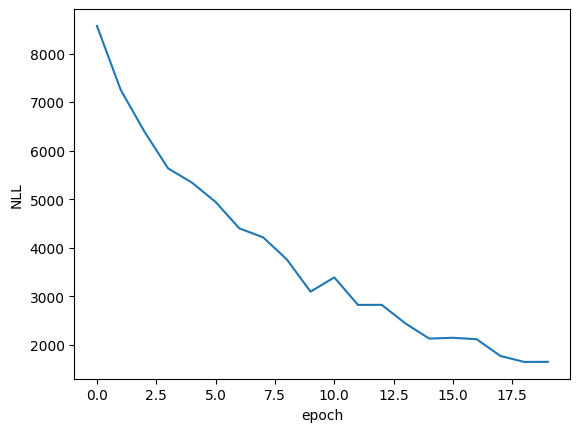

Training epoch 20


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=1.99e+3]


- Log loss: 1593.466552734375
Training epoch 21


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=1.81e+3]


- Log loss: 1334.0269775390625
Training epoch 22


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=1.87e+3]


- Log loss: 1195.9083251953125
Training epoch 23


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=1.52e+3]


- Log loss: 1193.138671875
Training epoch 24


100%|██████████| 75/75 [00:19<00:00,  3.79batch/s, loss=1.95e+3]


- Log loss: 1210.484375
Training epoch 25


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=1.47e+3]


- Log loss: 1119.9979248046875
Training epoch 26


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=1.81e+3]


- Log loss: 1225.9141845703125
Training epoch 27


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=2.11e+3]


- Log loss: 744.758544921875
Training epoch 28


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=1.49e+3]


- Log loss: 706.0158081054688
Training epoch 29


100%|██████████| 75/75 [00:19<00:00,  3.76batch/s, loss=1.57e+3]


- Log loss: 833.852294921875
Training epoch 30


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=1.21e+3]


- Log loss: 801.3665161132812
Training epoch 31


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=1.22e+3]


- Log loss: 765.1544189453125
Training epoch 32


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=1.02e+3]


- Log loss: 759.5040283203125
Training epoch 33


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=1.26e+3]


- Log loss: 800.3027954101562
Training epoch 34


100%|██████████| 75/75 [00:19<00:00,  3.79batch/s, loss=1.19e+3]


- Log loss: 698.4296264648438
Training epoch 35


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=1.36e+3]


- Log loss: 705.7037353515625
Training epoch 36


100%|██████████| 75/75 [00:19<00:00,  3.78batch/s, loss=975]    


- Log loss: 692.369384765625
Training epoch 37


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=1.25e+3]


- Log loss: 693.2970581054688
Training epoch 38


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=1.53e+3]


- Log loss: 567.3612670898438
Training epoch 39


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=1.16e+3]


- Log loss: 700.5927124023438


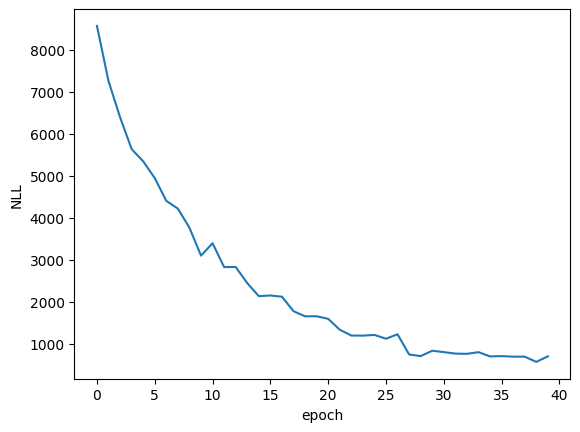

Training epoch 40


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=1.48e+3]


- Log loss: 712.2467041015625
Training epoch 41


100%|██████████| 75/75 [00:19<00:00,  3.76batch/s, loss=1.25e+3]


- Log loss: 537.3455200195312
Training epoch 42


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=949]    


- Log loss: 519.1951293945312
Training epoch 43


100%|██████████| 75/75 [00:19<00:00,  3.79batch/s, loss=1.2e+3] 


- Log loss: 533.861572265625
Training epoch 44


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=1.27e+3]


- Log loss: 558.48046875
Training epoch 45


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=657]    


- Log loss: 461.1736755371094
Training epoch 46


100%|██████████| 75/75 [00:19<00:00,  3.76batch/s, loss=737]    


- Log loss: 474.4067687988281
Training epoch 47


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=1.27e+3]


- Log loss: 558.5025024414062
Training epoch 48


100%|██████████| 75/75 [00:19<00:00,  3.76batch/s, loss=694]    


- Log loss: 467.4584655761719
Training epoch 49


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=637]    


- Log loss: 476.8817443847656
Training epoch 50


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=870]    


- Log loss: 437.1457214355469
Training epoch 51


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=1.15e+3]


- Log loss: 403.9983825683594
Training epoch 52


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=632]    


- Log loss: 431.63653564453125
Training epoch 53


100%|██████████| 75/75 [00:19<00:00,  3.84batch/s, loss=1e+3]   


- Log loss: 442.44842529296875
Training epoch 54


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=999]    


- Log loss: 463.2544860839844
Training epoch 55


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=524]    


- Log loss: 423.619140625
Training epoch 56


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=946]    


- Log loss: 394.9212951660156
Training epoch 57


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=538]    


- Log loss: 392.35894775390625
Training epoch 58


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=853]    


- Log loss: 468.2079162597656
Training epoch 59


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=900]    


- Log loss: 409.60711669921875


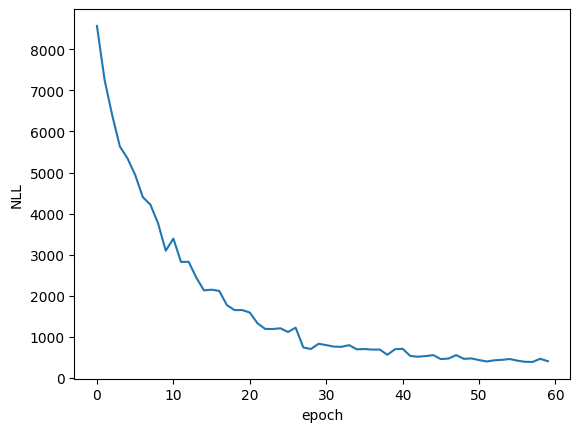

Training epoch 60


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=1.06e+3]


- Log loss: 468.9989013671875
Training epoch 61


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=645]    


- Log loss: 372.6983337402344
Training epoch 62


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=971]    


- Log loss: 357.9839172363281
Training epoch 63


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=403]    


- Log loss: 426.0887145996094
Training epoch 64


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=519]    


- Log loss: 359.7417297363281
Training epoch 65


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=642]    


- Log loss: 395.09124755859375
Training epoch 66


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=1.4e+3] 


- Log loss: 427.6879577636719
Training epoch 67


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=1.08e+3]


- Log loss: 302.2630920410156
Training epoch 68


100%|██████████| 75/75 [00:19<00:00,  3.95batch/s, loss=753]    


- Log loss: 363.4057312011719
Training epoch 69


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=966]    


- Log loss: 357.03131103515625
Training epoch 70


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=913]    


- Log loss: 390.4217834472656
Training epoch 71


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=1.01e+3]


- Log loss: 345.15509033203125
Training epoch 72


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=492]    


- Log loss: 352.651123046875
Training epoch 73


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=951]    


- Log loss: 307.14923095703125
Epoch 00074: reducing learning rate of group 0 to 5.0000e-05.
Training epoch 74


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=724]    


- Log loss: 314.08734130859375
Training epoch 75


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=1.67e+3]


- Log loss: 339.6268005371094
Training epoch 76


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=714]    


- Log loss: 311.3979187011719
Training epoch 77


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=548]    


- Log loss: 313.2485046386719
Training epoch 78


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=900]    


- Log loss: 339.7145080566406
Training epoch 79


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=543]    


- Log loss: 312.5151672363281
Epoch 00080: reducing learning rate of group 0 to 2.5000e-05.


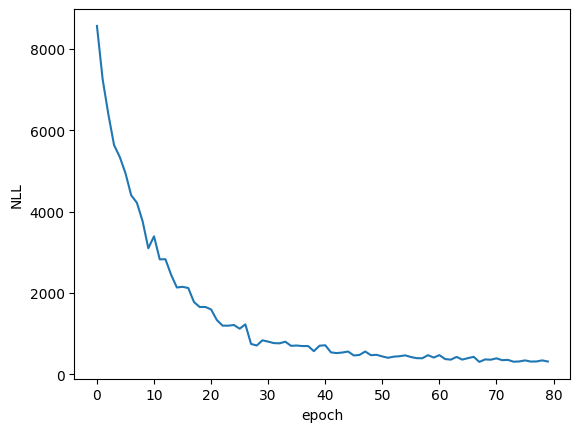

Training epoch 80


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=736]    


- Log loss: 292.11822509765625
Training epoch 81


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=537]    


- Log loss: 298.9774475097656
Training epoch 82


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=677]    


- Log loss: 302.6862487792969
Training epoch 83


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=724]    


- Log loss: 296.81488037109375
Training epoch 84


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=614]    


- Log loss: 312.9383850097656
Training epoch 85


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=651]    


- Log loss: 284.5796813964844
Training epoch 86


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=642]    


- Log loss: 311.36724853515625
Training epoch 87


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=737]    


- Log loss: 272.62469482421875
Training epoch 88


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=905]    


- Log loss: 274.02288818359375
Training epoch 89


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=645]    


- Log loss: 296.2393798828125
Training epoch 90


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=390]    


- Log loss: 271.9676513671875
Training epoch 91


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=871]    


- Log loss: 290.44561767578125
Training epoch 92


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=590]    


- Log loss: 288.4376220703125
Training epoch 93


100%|██████████| 75/75 [00:19<00:00,  3.84batch/s, loss=406]    


- Log loss: 304.72979736328125
Training epoch 94


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=664]    


- Log loss: 289.7126159667969
Training epoch 95


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=337]    


- Log loss: 280.1902770996094
Training epoch 96


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=630]    


- Log loss: 269.045654296875
Training epoch 97


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=622]    


- Log loss: 263.3508605957031
Training epoch 98


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=386]    


- Log loss: 272.531005859375
Training epoch 99


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=537]    


- Log loss: 285.3931884765625


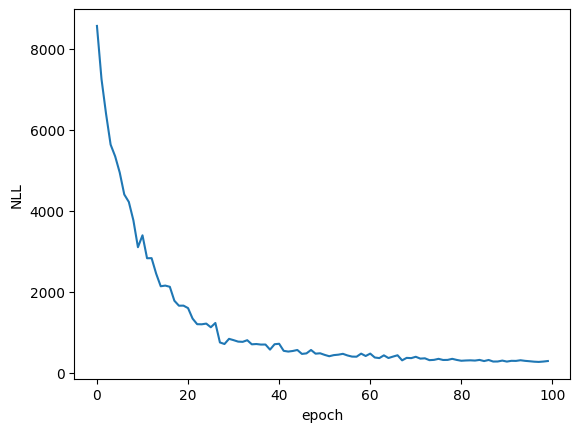

Training epoch 100


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=930]    


- Log loss: 276.55633544921875
Training epoch 101


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=311]    


- Log loss: 274.8245849609375
Training epoch 102


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=382]    


- Log loss: 262.2191162109375
Training epoch 103


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=531]    


- Log loss: 286.99383544921875
Training epoch 104


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=582]    


- Log loss: 275.0596618652344
Training epoch 105


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=532]    


- Log loss: 292.4277648925781
Training epoch 106


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=437]    


- Log loss: 268.111328125
Training epoch 107


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=332]    


- Log loss: 270.29693603515625
Training epoch 108


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=443]    


- Log loss: 268.54547119140625
Epoch 00109: reducing learning rate of group 0 to 1.2500e-05.
Training epoch 109


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=439]    


- Log loss: 276.87109375
Training epoch 110


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=686]    


- Log loss: 275.56451416015625
Training epoch 111


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=646]    


- Log loss: 258.6185607910156
Training epoch 112


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=367]


- Log loss: 284.28961181640625
Training epoch 113


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=1.07e+3]


- Log loss: 264.5100402832031
Training epoch 114


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=663]    


- Log loss: 281.56683349609375
Training epoch 115


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=333]    


- Log loss: 277.5262145996094
Training epoch 116


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=701]


- Log loss: 258.1044616699219
Training epoch 117


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=374]    


- Log loss: 271.80780029296875
Training epoch 118


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=369]    


- Log loss: 278.4007568359375
Training epoch 119


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=457]


- Log loss: 266.13519287109375


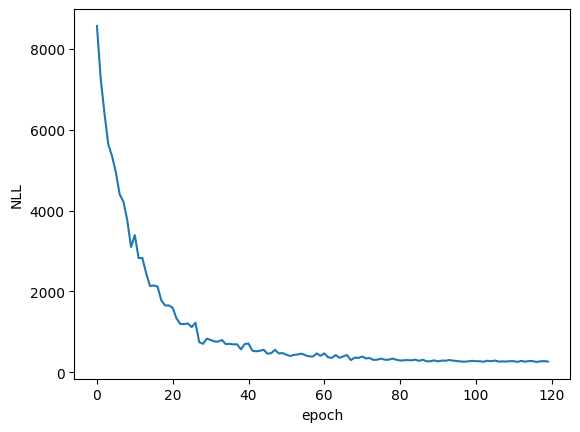

Training epoch 120


100%|██████████| 75/75 [00:19<00:00,  3.95batch/s, loss=391]    


- Log loss: 254.6993408203125
Training epoch 121


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=562]


- Log loss: 266.1490478515625
Training epoch 122


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=378]    


- Log loss: 273.6045227050781
Training epoch 123


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=441]


- Log loss: 266.01446533203125
Training epoch 124


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=329]    


- Log loss: 265.2169189453125
Training epoch 125


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=453]    


- Log loss: 294.66571044921875
Training epoch 126


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=437]   


- Log loss: 257.5443420410156
Epoch 00127: reducing learning rate of group 0 to 6.2500e-06.
Training epoch 127


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=343]    


- Log loss: 275.2976379394531
Training epoch 128


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=434]


- Log loss: 260.19586181640625
Training epoch 129


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=546]   


- Log loss: 260.77740478515625
Training epoch 130


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=423]


- Log loss: 253.46759033203125
Training epoch 131


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=539]


- Log loss: 265.1648254394531
Training epoch 132


100%|██████████| 75/75 [00:18<00:00,  3.97batch/s, loss=536]


- Log loss: 252.45529174804688
Training epoch 133


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=349]    


- Log loss: 251.37623596191406
Training epoch 134


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=387]    


- Log loss: 254.60171508789062
Training epoch 135


100%|██████████| 75/75 [00:18<00:00,  3.95batch/s, loss=296] 


- Log loss: 262.7015380859375
Training epoch 136


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=301]


- Log loss: 250.54212951660156
Training epoch 137


100%|██████████| 75/75 [00:18<00:00,  3.95batch/s, loss=559]


- Log loss: 252.7396240234375
Training epoch 138


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=1.48e+3]


- Log loss: 262.3475036621094
Training epoch 139


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=226]    


- Log loss: 247.52703857421875


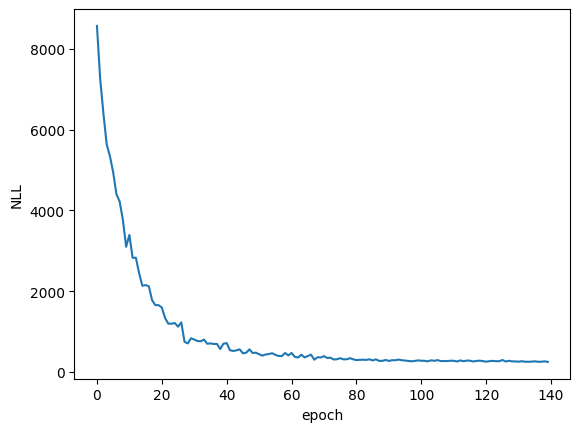

Training epoch 140


100%|██████████| 75/75 [00:19<00:00,  3.79batch/s, loss=411]


- Log loss: 249.2288055419922
Training epoch 141


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=262]    


- Log loss: 254.332763671875
Training epoch 142


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=579]    


- Log loss: 244.3323516845703
Training epoch 143


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=358]   


- Log loss: 251.408447265625
Training epoch 144


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=458]    


- Log loss: 246.31231689453125
Training epoch 145


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=497]    


- Log loss: 249.0279541015625
Training epoch 146


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=359]    


- Log loss: 252.5499267578125
Training epoch 147


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=744]    


- Log loss: 271.98626708984375
Training epoch 148


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=509]


- Log loss: 255.5203399658203
Epoch 00149: reducing learning rate of group 0 to 3.1250e-06.
Training epoch 149


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=641]


- Log loss: 245.26031494140625
Training epoch 150


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=479]


- Log loss: 250.1876983642578
Training epoch 151


100%|██████████| 75/75 [00:18<00:00,  3.95batch/s, loss=1.03e+3]


- Log loss: 243.41676330566406
Training epoch 152


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=263]    


- Log loss: 262.6264343261719
Training epoch 153


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=501]


- Log loss: 250.44070434570312
Training epoch 154


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=391]


- Log loss: 252.62953186035156
Training epoch 155


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=316]


- Log loss: 252.14991760253906
Training epoch 156


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=467]


- Log loss: 243.63818359375
Training epoch 157


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=632]


- Log loss: 249.8526153564453
Epoch 00158: reducing learning rate of group 0 to 1.5625e-06.
Training epoch 158


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=504]    


- Log loss: 252.25634765625
Training epoch 159


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=215]    


- Log loss: 250.08079528808594


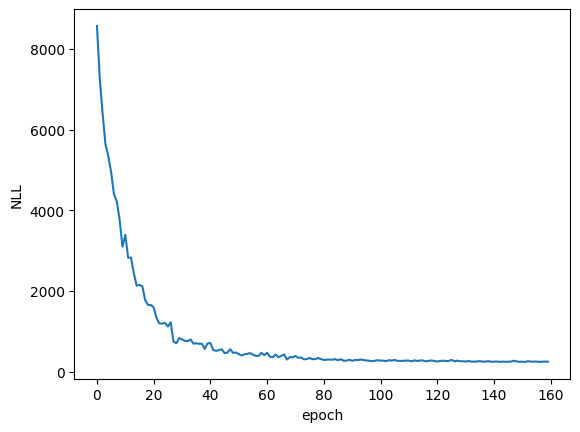

Training epoch 160


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=727]    


- Log loss: 243.3523712158203
Training epoch 161


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=327]


- Log loss: 244.40040588378906
Training epoch 162


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=291]


- Log loss: 253.2161102294922
Training epoch 163


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=563]


- Log loss: 243.60826110839844
Training epoch 164


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=284]    


- Log loss: 241.75804138183594
Training epoch 165


100%|██████████| 75/75 [00:18<00:00,  3.96batch/s, loss=217]


- Log loss: 247.50936889648438
Training epoch 166


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=441]


- Log loss: 250.46360778808594
Training epoch 167


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=230]   


- Log loss: 241.86068725585938
Training epoch 168


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=451]


- Log loss: 255.874267578125
Training epoch 169


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=873]


- Log loss: 247.623291015625
Training epoch 170


100%|██████████| 75/75 [00:18<00:00,  3.96batch/s, loss=489]    


- Log loss: 251.88307189941406
Epoch 00171: reducing learning rate of group 0 to 7.8125e-07.
Training epoch 171


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=613]    


- Log loss: 243.77195739746094
Training epoch 172


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=738]


- Log loss: 244.64955139160156
Training epoch 173


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=342]    


- Log loss: 251.3983612060547
Training epoch 174


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=211]


- Log loss: 253.1169891357422
Training epoch 175


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=622]


- Log loss: 242.5162811279297
Training epoch 176


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=282]


- Log loss: 248.4258575439453
Epoch 00177: reducing learning rate of group 0 to 3.9063e-07.
Training epoch 177


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=423]


- Log loss: 250.3170166015625
Training epoch 178


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=713]    


- Log loss: 244.6536102294922
Training epoch 179


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=429]


- Log loss: 246.760986328125


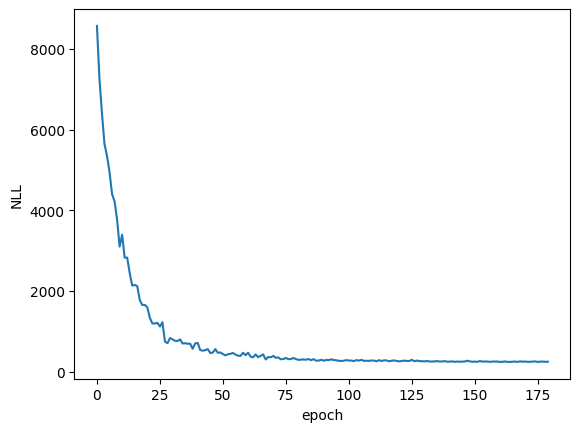

Training epoch 180


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=355]    


- Log loss: 250.58407592773438
Training epoch 181


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=566]


- Log loss: 252.082763671875
Training epoch 182


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=356]    


- Log loss: 251.5556640625
Epoch 00183: reducing learning rate of group 0 to 1.9531e-07.
Training epoch 183


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=580]


- Log loss: 249.5811309814453
Training epoch 184


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=442]  


- Log loss: 240.09417724609375
Training epoch 185


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=237]


- Log loss: 255.4959716796875
Training epoch 186


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=425]


- Log loss: 242.67588806152344
Training epoch 187


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=386]    


- Log loss: 241.78628540039062
Training epoch 188


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=622]


- Log loss: 244.54510498046875
Training epoch 189


100%|██████████| 75/75 [00:18<00:00,  3.95batch/s, loss=559]


- Log loss: 244.74606323242188
Training epoch 190


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=395]


- Log loss: 247.35450744628906
Epoch 00191: reducing learning rate of group 0 to 9.7656e-08.
Training epoch 191


100%|██████████| 75/75 [00:18<00:00,  3.96batch/s, loss=328]


- Log loss: 244.1126708984375
Training epoch 192


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=536]    


- Log loss: 243.51577758789062
Training epoch 193


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=303]


- Log loss: 250.40478515625
Training epoch 194


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=293]


- Log loss: 244.7145233154297
Training epoch 195


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=449]    


- Log loss: 241.77781677246094
Training epoch 196


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=638]


- Log loss: 241.43038940429688
Epoch 00197: reducing learning rate of group 0 to 4.8828e-08.
Training epoch 197


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=415]


- Log loss: 242.6158447265625
Training epoch 198


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=326]


- Log loss: 245.93777465820312
Training epoch 199


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=631]


- Log loss: 246.1427459716797


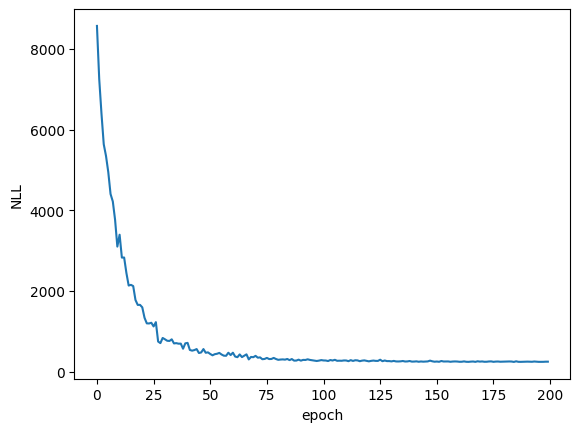

Training epoch 200


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=388]    


- Log loss: 240.5055389404297
Training epoch 201


100%|██████████| 75/75 [00:19<00:00,  3.84batch/s, loss=451]


- Log loss: 243.79611206054688
Training epoch 202


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=463]


- Log loss: 251.421875
Epoch 00203: reducing learning rate of group 0 to 2.4414e-08.
Training epoch 203


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=313]    


- Log loss: 245.43621826171875
Training epoch 204


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=406]


- Log loss: 243.06431579589844
Training epoch 205


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=388]    


- Log loss: 249.00755310058594
Training epoch 206


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=595]


- Log loss: 252.95164489746094
Training epoch 207


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=372]


- Log loss: 242.87124633789062
Training epoch 208


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=367]   


- Log loss: 238.7819366455078
Training epoch 209


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=291]    


- Log loss: 253.10325622558594
Training epoch 210


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=245]


- Log loss: 245.47616577148438
Training epoch 211


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=597]    


- Log loss: 248.58082580566406
Training epoch 212


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=232]


- Log loss: 247.18614196777344
Training epoch 213


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=285]    


- Log loss: 243.66444396972656
Training epoch 214


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=343]


- Log loss: 243.75828552246094
Epoch 00215: reducing learning rate of group 0 to 1.2207e-08.
Training epoch 215


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=487]


- Log loss: 245.98619079589844
Training epoch 216


100%|██████████| 75/75 [00:19<00:00,  3.87batch/s, loss=486]


- Log loss: 242.78054809570312
Training epoch 217


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=654]


- Log loss: 245.10008239746094
Training epoch 218


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=480]    


- Log loss: 244.62445068359375
Training epoch 219


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=602]


- Log loss: 247.7960968017578


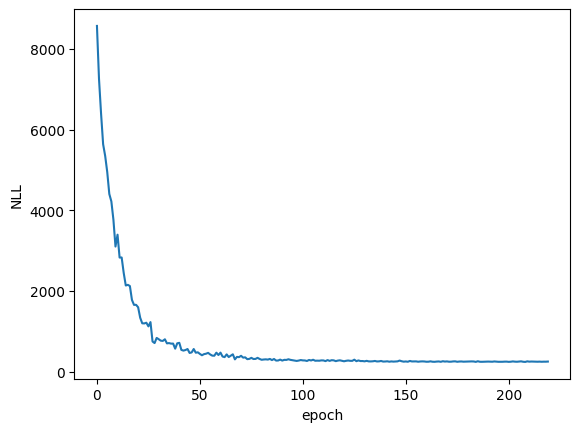

Training epoch 220


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=495]    


- Log loss: 243.51031494140625
Training epoch 221


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=600]


- Log loss: 243.46945190429688
Training epoch 222


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=293]


- Log loss: 244.75851440429688
Training epoch 223


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=620]


- Log loss: 251.07699584960938
Training epoch 224


100%|██████████| 75/75 [00:19<00:00,  3.90batch/s, loss=407]


- Log loss: 245.07933044433594
Training epoch 225


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=281]    


- Log loss: 243.1008758544922
Training epoch 226


100%|██████████| 75/75 [00:19<00:00,  3.88batch/s, loss=495]    


- Log loss: 242.5858917236328
Training epoch 227


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=553]


- Log loss: 243.31764221191406
Training epoch 228


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=581]


- Log loss: 247.56411743164062
Training epoch 229


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=366]


- Log loss: 246.22341918945312
Training epoch 230


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=463]


- Log loss: 241.33238220214844
Training epoch 231


100%|██████████| 75/75 [00:19<00:00,  3.91batch/s, loss=516]    


- Log loss: 240.22242736816406
Training epoch 232


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=453]    


- Log loss: 245.24981689453125
Training epoch 233


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=352]


- Log loss: 255.580322265625
Training epoch 234


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=615]


- Log loss: 248.74244689941406
Training epoch 235


100%|██████████| 75/75 [00:19<00:00,  3.84batch/s, loss=229]


- Log loss: 252.36973571777344
Training epoch 236


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=540]


- Log loss: 251.24984741210938
Training epoch 237


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=403]


- Log loss: 243.15277099609375
Training epoch 238


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=608]    


- Log loss: 245.21456909179688
Training epoch 239


100%|██████████| 75/75 [00:19<00:00,  3.84batch/s, loss=359]


- Log loss: 249.01507568359375


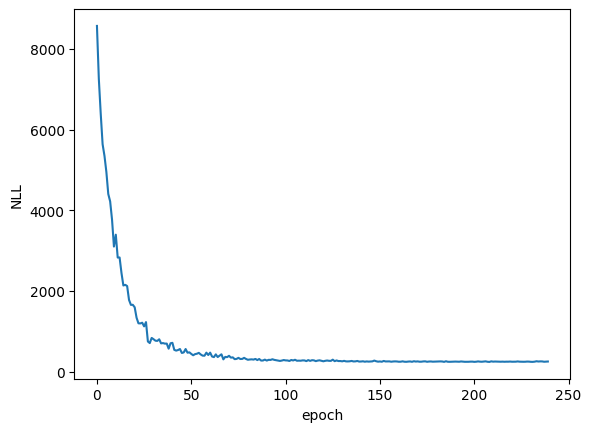

Training epoch 240


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=346]


- Log loss: 250.35693359375
Training epoch 241


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=301]


- Log loss: 246.09962463378906
Training epoch 242


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=354]    


- Log loss: 246.3521728515625
Training epoch 243


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=437]    


- Log loss: 245.9977569580078
Training epoch 244


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=517]


- Log loss: 246.72393798828125
Training epoch 245


100%|██████████| 75/75 [00:19<00:00,  3.93batch/s, loss=658]


- Log loss: 243.35433959960938
Training epoch 246


100%|██████████| 75/75 [00:19<00:00,  3.92batch/s, loss=606]


- Log loss: 247.47898864746094
Training epoch 247


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=507]


- Log loss: 241.3679656982422
Training epoch 248


100%|██████████| 75/75 [00:19<00:00,  3.94batch/s, loss=505]    


- Log loss: 242.36370849609375
Training epoch 249


100%|██████████| 75/75 [00:19<00:00,  3.89batch/s, loss=572]


- Log loss: 252.02069091796875


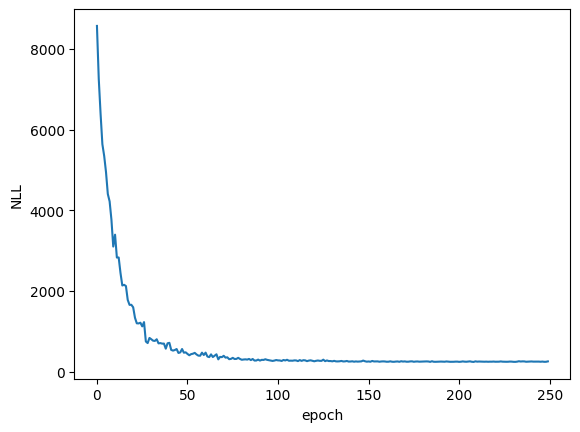

Training complete!


In [42]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
loss_fn = loss

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=250)

In [43]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [44]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [45]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  208



In [46]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [47]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(np.squeeze(out), np.squeeze(batch["target"]))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:18<00:00, 13.67it/s]

Mean Loss: 914.8102
Mean IoU: 0.5903
Mean Accuracy: 0.9852
Mean Recall: 0.6712
Mean False Positive Rate: 0.0028
Mean False Negative Rate: 0.8428


neg
1210.083984375


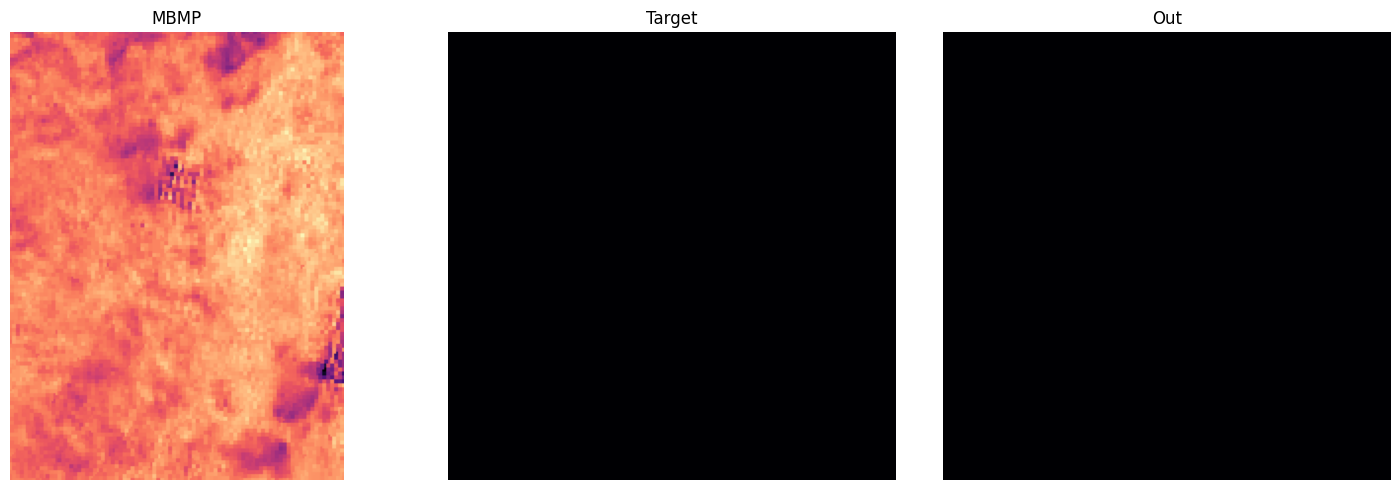

pos
1199.1463623046875


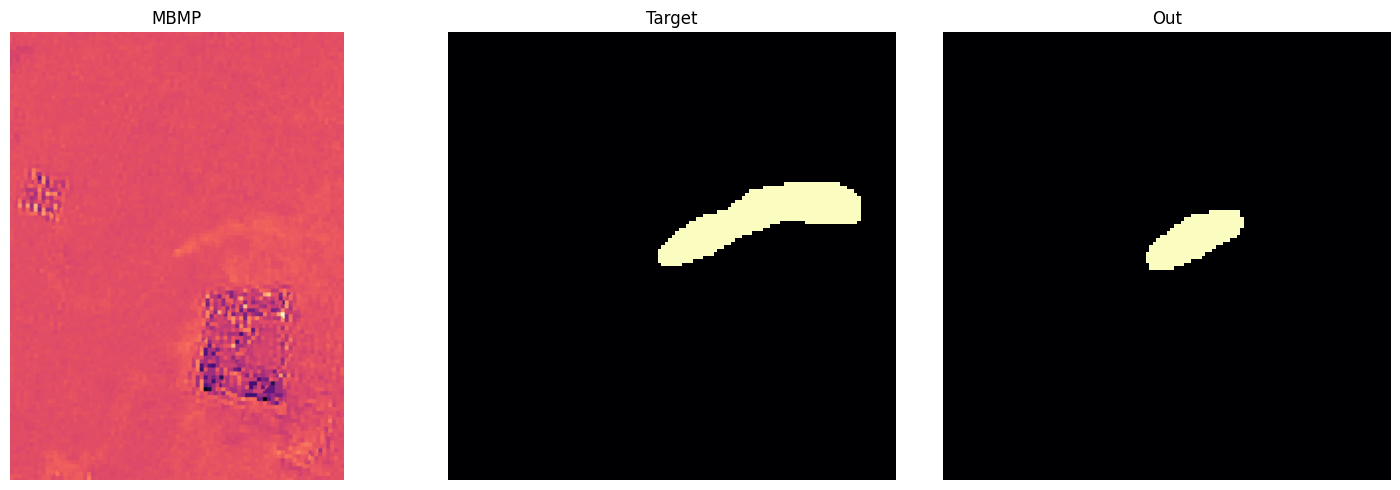

neg
19.718074798583984


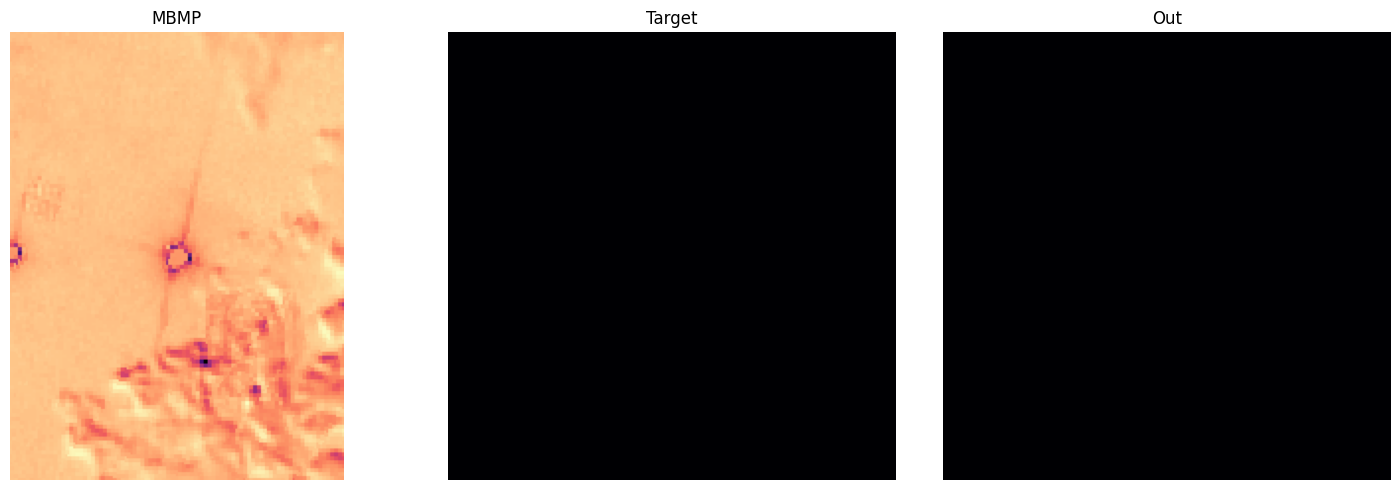

pos
2395.614501953125


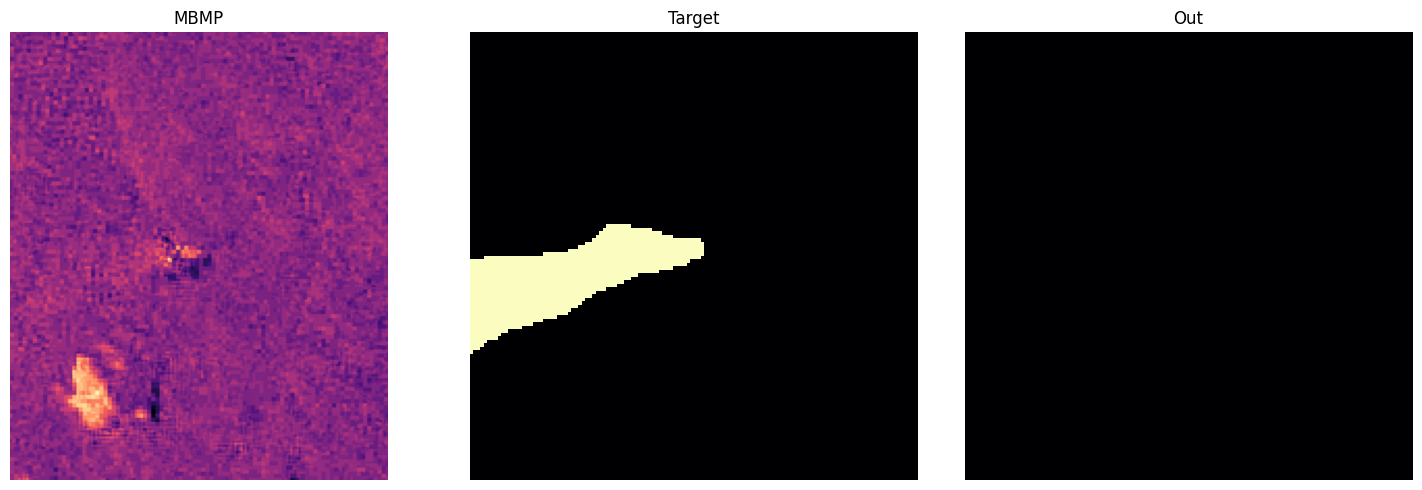

pos
3572.4560546875


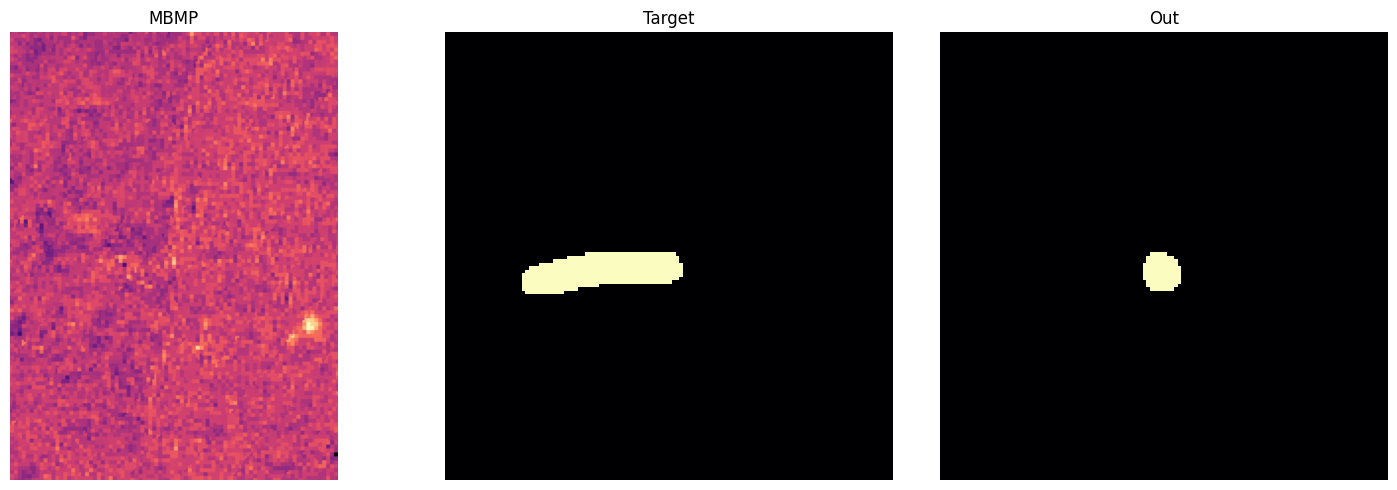

neg
52.52777099609375


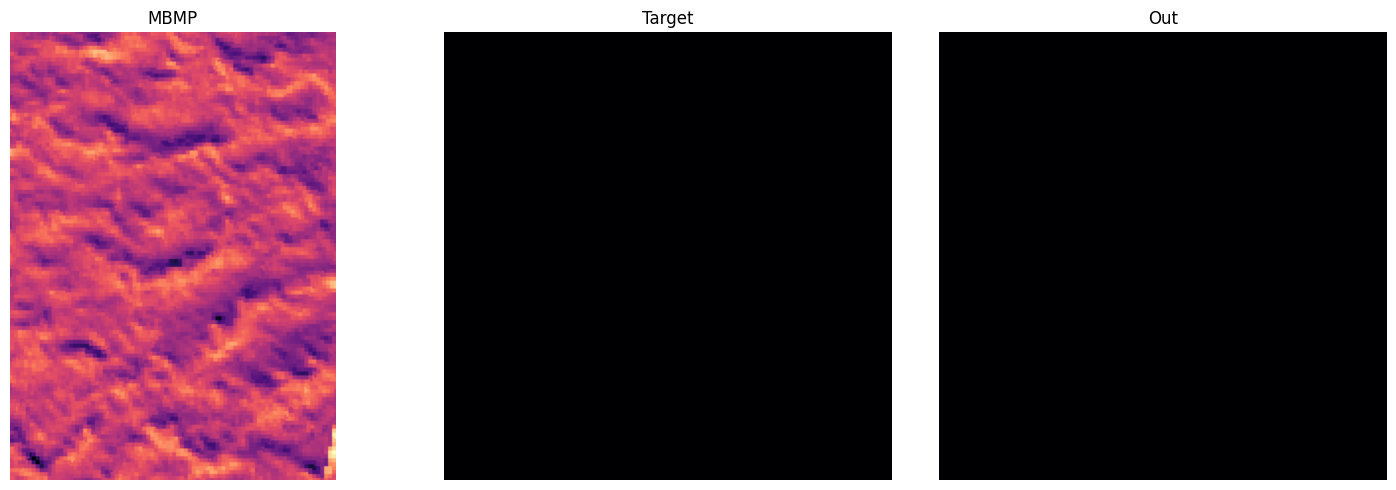

neg
29.917343139648438


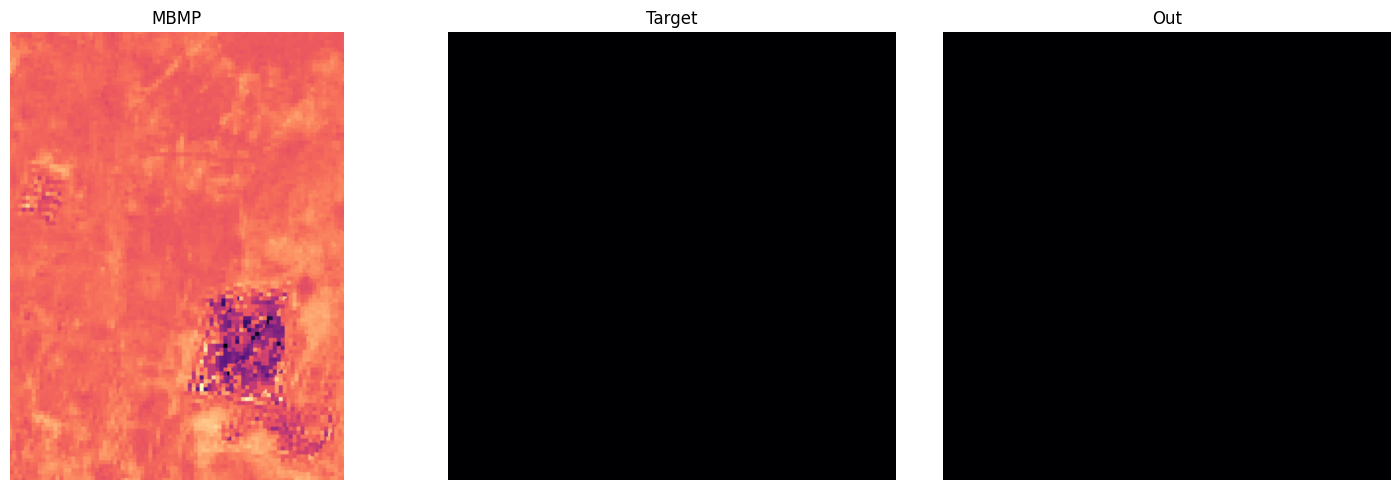

neg
436.01220703125


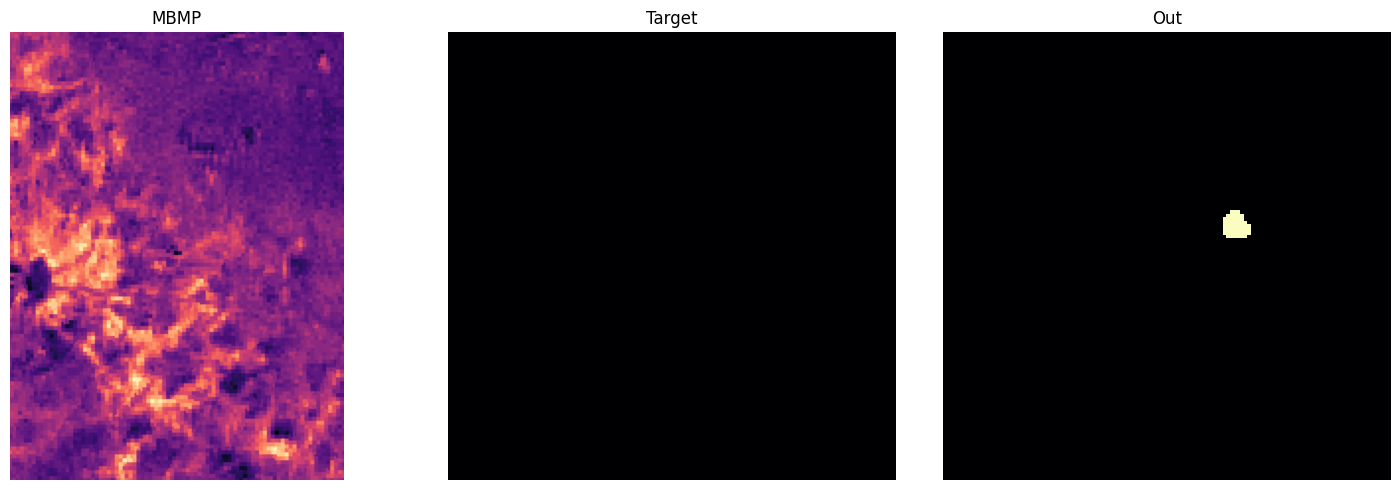

neg
394.5147705078125


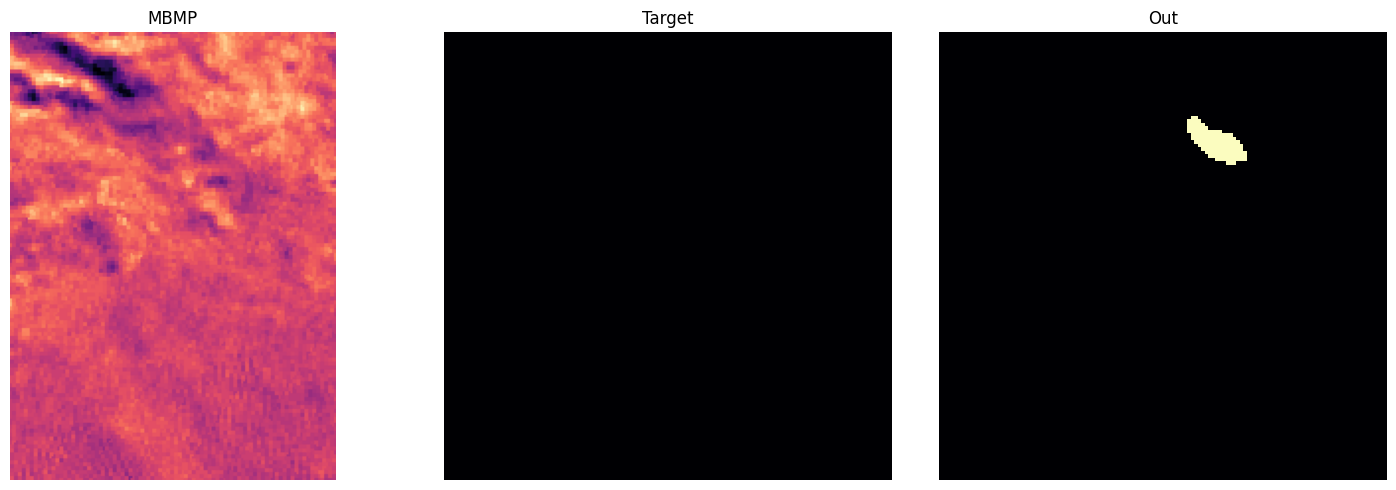

pos
2678.55810546875


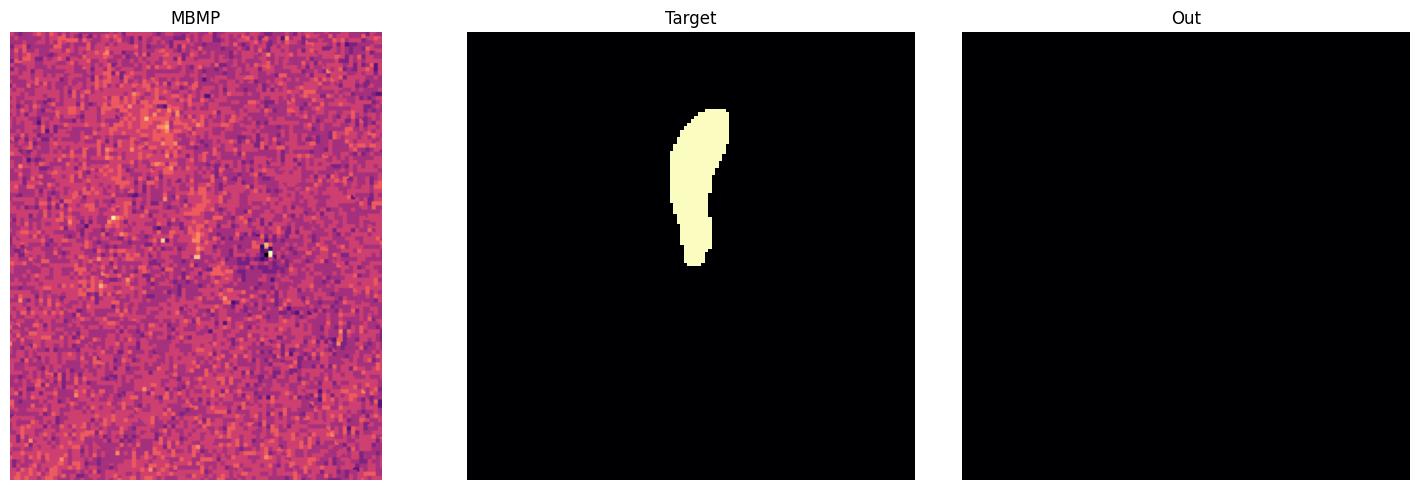

In [48]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

#     print(image1.shape, image2.shape, image3.shape)
    print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==10): break
